In [20]:
from __future__ import print_function
%matplotlib inline 
# make plots show in ipython notebook

from gensim import models, matutils, utils
import numpy as np
import os, sys
import logging
import nltk
from nltk.corpus import stopwords
import random
import pandas as pd
import pylab
import itertools
import string
from sklearn.metrics.pairwise import euclidean_distances

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# Get logging information

In [16]:
# Load pre-trained representation model. Whether load those model at the same time depends on the space of your RAM

# Load pre-trained word2vec model from disk
word2vec_model = models.word2vec.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 
#word2vec_model = models.word2vec.Word2Vec.load_word2vec_format('glove.6B.100d.word2vec.txt', binary = False)

# word2vec_model.vocab: 3000000  words for word2vec_model.
# each word are represented as a vector with 300 terms
# word2vec_model.syn0: matrix for the model
# word2vec_model.syn0.shape: check the shape of this matrix
# Normalize all vectors in this model. 
# So we can use dot product to calculate cosine similarity which is more efficient
word2vec_model.init_sims(replace = True)
# The normalized vectors are stored in model.syn0 and model.syn0norm. These are the same.

INFO:gensim.models.word2vec:loading projection weights from GoogleNews-vectors-negative300.bin
INFO:gensim.models.word2vec:loaded (3000000L, 300L) matrix from GoogleNews-vectors-negative300.bin
INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


In [17]:
# Load two files
target_file = pd.read_table("target_collection", compression = None, header = 0, sep = '\t')
logger.info(("target file loaded. " + str(np.shape(target_file)[0]) + " documents."))
query_file = pd.read_table("queries_val", compression = None, header = 0, sep = '\t')
logger.info(("query file loaded. " + str(np.shape(query_file)[0]) + " queries."))

INFO:root:target file loaded. 17784 documents.
INFO:root:query file loaded. 1000 queries.


In [24]:
target_file.head()

,sent_id,img_id,txt_caption
0,0,EiS5L2wmSbJq8Y3u,A picture of a man standing next to a horse on...
1,1,P5xKs0Q1QB8vbgVH,A man is holding up a fish.
2,2,u5EXhe28CW4XySoT,There is man motioning with his hands in front...
3,3,cpmk_ry7TG3lTvlX,A man wearing a green coat holding something i...
4,4,IawGgdRJoTmZSYEs,Chairs in a circle in front of some books.


In [19]:
def tokenize(text):
    """split text into words, remove punctuations, remove stop words"""
    tokens0 = nltk.word_tokenize(text)
    tokens1 = [t for t in tokens0 if t not in [',', '.', '``', '"', "'", "''"]]
    tokens = [t for t in tokens1 if t not in stopwords.words('english')]
    return tokens

In [21]:
target_dic = {}

In [28]:
def buildDic():
    """build dictionary for all targets and save word vectors for each target as matrix"""
    for row in target_file.itertuples():
        tokens = tokenize(row[3])
        target_dic[row[1]] = [word2vec_model[tok] for tok in tokens if tok in word2vec_model.vocab]

In [29]:
buildDic()

F:\Program Files\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [30]:
def shortestDistance(mat1, mat2):
    """calculate distance for moving all words in query matrix (mat1) to target matrix (mat2)"""
    dist_mat = euclidean_distances(mat1, mat2) # euclidean distances for every pair of words
    shortestDist = np.mean([np.min(word_dis) for word_dis in dist_mat]) # average of shortest distance for moving one word to another word
    return shortestDist

In [53]:
def querySimilarity(query):
    """rank all targets for each query"""
    tokens = tokenize(query)
    query_mat = [word2vec_model[t] for t in tokens if t in word2vec_model.vocab] # transform query to query matrix
    sims = [shortestDistance(query_mat, target_dic[k]) for k in target_dic.keys()]
    # sort by similarity score (distance) increasingly
    sims = np.array(sims)
    best0 = np.argsort(sims)[:1000]
    best = [best0, sims[best0]]
    return best

In [45]:
def getAveragePrecision(query_img_id, best, cutoff):
    """get AP for a query at recall@cutoff"""
    tp_series = np.where(np.asarray([target_file['img_id'][x] for x in best[:cutoff]]) == query_img_id)[0]
    tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
    tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn
    averPrec = sum(tp_tpfp)/tpfn
    return averPrec

In [103]:
def precAndRec(query_img_id, best):
    """compute precision-recall curve for a query"""
    tp_series = np.where(np.array([target_file['img_id'][x] for x in best]) == query_img_id)[0]
    # tp_accu = np.array([0] * len(tp_series))
    tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
    tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn， denominator for recall
    tmp = 0
    i = 0
    precRecall_arr = [0.0] * 11
    # computation of precision based on 11 standard recall levels      
    for tmp in range(len(tp_tpfp)):
        while (i/10.0) <= ((tmp + 1.0) / tpfn):
            precRecall_arr[i] = tp_tpfp[tmp]
            i += 1
    return np.array(precRecall_arr)


In [101]:
def meanResult(modelName, graph = False):
    """calculate average of AP and precision-recall for all queries"""
    sum_averagePrecision = []
    sum_precision = np.array([0.0] * 11)
    # loop over all queries
    for row in query_file.itertuples():
        query, query_img_id = row[3], row[2]
        best = querySimilarity(query)
        sum_averagePrecision.append(getAveragePrecision(query_img_id, best[0], 1000))
        if row[0] % 100 == 0:
            logger.info(row[0])
        if graph:
            prec = precAndRec(query_img_id, best[0])
            sum_precision += prec
    
    meanAP = np.mean(sum_averagePrecision)
    print("Mean Average Precision of " + modelName + " is: ", str(meanAP))
    if graph:
        pylab.plot(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), sum_precision / 1000)
        pylab.xlabel('recall')
        pylab.ylabel('precision')
        pylab.title(modelName)

INFO:root:0
INFO:root:100
INFO:root:200
INFO:root:300
INFO:root:400
INFO:root:500
INFO:root:600
INFO:root:700
INFO:root:800
INFO:root:900


Mean Average Precision of Word Mover Distance Model is:  0.22629868106


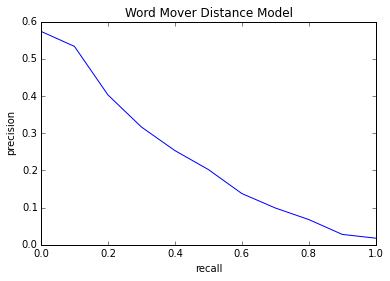

In [105]:
meanResult('Word Mover Distance Model', graph = True) # it takes about 2.3 hours

In [106]:
test_queries = ["Two people in a group of four are holding awards as they pose for a picture.",\
                "A woman in a red dress is posing with an axe.",\
                "Two soccer plays stand next to each other with soccer balls in front of them."]
test_keys = ["CbnA_e6AW6U7Ycoa", "PaqtOaYmQmXkqW2i", "IPcFtNL-7EQ6Z0yu"]

In [107]:
def testExamples(query, key):
    best = querySimilarity(query)
    target_doc = target_file['txt_caption'][best[0][:1000]]
    target_key = target_file['img_id'][best[0][:1000]]
    d = {'target':target_doc, 'match':[key]*1000 == target_key, 'score':best[1][:1000]}
    d = pd.DataFrame(d)
    for i in range(20):
        print(d['match'].iloc[i])
        print(d['score'].iloc[i])
        print(query)
        print(d['target'].iloc[i])
        print()
    return d

In [108]:
test1 = testExamples(test_queries[0], test_keys[0])

False
0.481899
Two people in a group of four are holding awards as they pose for a picture.
A group of people where all but two of the people are holding awards.

False
0.486348
Two people in a group of four are holding awards as they pose for a picture.
A group of seven Asian young people pose for a picture in a cafe.

False
0.542263
Two people in a group of four are holding awards as they pose for a picture.
Three people posing for a picture holding a trophy.

False
0.54721
Two people in a group of four are holding awards as they pose for a picture.
A group of four older people pose for a portrait.

False
0.55482
Two people in a group of four are holding awards as they pose for a picture.
Two men holding a trophy with a group of people applauding behind them.

False
0.561326
Two people in a group of four are holding awards as they pose for a picture.
Two men pose for a picture holding championship belts, who appear to be wrestlers but one's vest says "lumberjack.".

False
0.572742
Tw

In [109]:
test2 = testExamples(test_queries[1], test_keys[1])

False
0.0
A woman in a red dress is posing with an axe.
A woman in a dress and heels posing on a red carpet.

False
0.0
A woman in a red dress is posing with an axe.
A young woman in a tan dress posing for a picture at the red carpet.

False
0.0
A woman in a red dress is posing with an axe.
A red haired woman in a dress is posing.

False
0.0
A woman in a red dress is posing with an axe.
A woman with red hair in a brown dress posing in front of a curtain.

False
0.0
A woman in a red dress is posing with an axe.
A picture of a woman in a red dress posing for the camera.

False
9.76563e-05
A woman in a red dress is posing with an axe.
A smiling, tanned brunette woman wearing a sleeveless dress, and gladiator sandals, and holding a clutch, stands posing on the red carpet for the camera, with one hand on her hip.

False
9.76563e-05
A woman in a red dress is posing with an axe.
A skinny woman in a red dress posing for a picture in front of a movie poster.

False
0.141573
A woman in a red dre

In [110]:
test3 = testExamples(test_queries[2], test_keys[2])

True
0.289566
Two soccer plays stand next to each other with soccer balls in front of them.
Two soccer players in orange and black striped t-shirts, stand waiting in front of some balls.

True
0.570836
Two soccer plays stand next to each other with soccer balls in front of them.
Two men are standing with soccer balls.

False
0.678701
Two soccer plays stand next to each other with soccer balls in front of them.
Two men play soccer inside.

False
0.683275
Two soccer plays stand next to each other with soccer balls in front of them.
Two opposing soccer players going for the ball.

False
0.688384
Two soccer plays stand next to each other with soccer balls in front of them.
Two opposing teammates trying to get control of the soccer ball during a game.

False
0.712177
Two soccer plays stand next to each other with soccer balls in front of them.
Two soccer players battle for the ball.

False
0.733084
Two soccer plays stand next to each other with soccer balls in front of them.
Two girls stand